In [1]:
import gym
import gym_Snake
import time
import sys
from IPython.display import clear_output
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import os

#### QLearning algorithm

In [2]:
class QLearning:
    def __init__(self, n_actions, n_states, discount=0.9, alpha = 0.01, epsilon=0.9, min_epsilon = 0.1, decay = 1):
        self.n_actions = n_actions
        self.n_states = n_states
        self.Q = np.zeros([n_states, n_actions])
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.decay = decay
        self.chronology = []
        
    def update_epsilon(self):
#         if self.epsilon > self.min_epsilon: self.epsilon = 1 / (1 / self.epsilon + self.decay)
        if self.epsilon > self.min_epsilon: self.epsilon = self.epsilon * self.decay
            
    def act(self):
        if (np.random.uniform() < self.epsilon):
            return np.random.choice(self.n_actions)
        return np.argmax(self.Q[self.state, :])
    
    def update(self, action, reward, state, add_batch=True):
        if add_batch: self.chronology.append([self.state, action, reward, state])
        self.Q[self.state, action] += self.alpha * np.max(reward + self.discount * self.Q[state, :] - self.Q[self.state, action])        
#         self.alpha += 1 / ( self.alpha + self.decay)
        self.state = state

    def reset(self, state):
        self.state = state
        
    def play_batch(self, nb_batchs):
        prev_state = self.state
        arr = np.array(self.chronology)
        for s,a,r,sn in arr[np.random.choice(arr.shape[0], size=nb_batchs, replace=False), :]:
            # Reset position
            self.reset(s)
            # Update algorithm
            self.update(a, r, sn, add_batch = False)
        # Reset real state
        self.reset(prev_state)


In [3]:
class SARSA:
    def __init__(self, n_actions, n_states, discount=0.9, alpha = 0.01, epsilon=0.1, min_epsilon = 0.1, decay = 0):
        self.n_actions = n_actions
        self.n_states = n_states
        self.Q = np.zeros([n_states, n_actions])
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.decay = decay
        self.state = 0  # Set initial state
        self.chronology = []
        
        
    def update_epsilon(self):
#         if self.epsilon > self.min_epsilon: self.epsilon = 1 / (1 / self.epsilon + self.decay)
        if self.epsilon > self.min_epsilon: self.epsilon = self.epsilon * self.decay
            
    def act(self):
        ## by default, act greedily
        if (np.random.uniform() < self.epsilon):
            return np.random.randint(self.n_actions)
        return np.argmax(self.Q[self.state, :])

    def update(self, action, reward, state, add_batch = True):
        if add_batch: self.chronology.append([self.state, action, reward, state])
        ## fill in
        next_action = np.argmax(self.Q[state, :])
        self.Q[self.state, action] += self.alpha * np.max(reward + self.discount * self.Q[state, :] - self.Q[self.state, action])        
        self.Q[self.state, action] = self.alpha * (reward + self.discount * self.Q[state, next_action]) + (1 - self.alpha) * self.Q[self.state, action]
        self.state = state

    def reset(self, state):
        self.state = state
        
    def play_batch(self, nb_batchs):
        prev_state = self.state
        arr = np.array(self.chronology)
        for s,a,r,sn in arr[np.random.choice(arr.shape[0], size=nb_batchs, replace=False), :]:
            # Reset position
            self.reset(s)
            # Update algorithm
            self.update(a, r, sn, add_batch = False)
        # Reset real state
        self.reset(prev_state)

#### Create env

In [4]:
custom_rewards = {
    "REWARD_TARGET": 10,
    "REWARD_COLLISION": -10,
    "REWARD_TOWARD": 0,
    "REWARD_AWAY": 0
}

env = gym.make('Snake-v0', 
               player = 'computer', 
               shape = 'Normal', 
               state_mode = 'states', 
               reward_mode = 'normal', 
               width = 9, 
               height = 9, 
               solid_border = True,
               rewards = custom_rewards)
print(env.observation_space)
print(env.action_space)

Discrete(1024)
Discrete(3)


#### Iteration logic

In [5]:
def play_epoch(algo, env, render = False, sleep_time = 0.5):
    
    # Reset env
    obs = env.reset()
    algo.reset(obs)

    done = False
    
    # Sum the rewards
    total_rew = 0
    
    while not done:
        # Show
        if render: env.render()
        # Choose next action
        new_act = algo.act()
        # Act in the env
        obs, reward, done, info = env.step(new_act)
        # Store reward
        total_rew += reward
        # Update algorithm
        algo.update(new_act, reward, obs)
        # Slow render
        if render: time.sleep(sleep_time)
            
    # Return total reward
    return total_rew

#### Init QLearning algorithm

In [6]:
# Compute decai in order to reach given value after n iterations
n = 300000
initial_epsilon = 1
min_epsilon = 0.1
opt_decay = (min_epsilon / initial_epsilon)**(1/n)

In [7]:
# QL = QLearning(n_actions = env.action_space.n,
#                 n_states = env.observation_space.n, 
#                 discount=0.9, 
#                 alpha = 0.1, 
#                 epsilon=1, 
#                 decay = 0.00001)

QL = QLearning(n_actions = env.action_space.n,
               n_states = env.observation_space.n, 
               discount = 0.9, 
               alpha = 0.2, 
               epsilon = initial_epsilon, 
               min_epsilon = min_epsilon,
               decay = opt_decay)

SA = SARSA(n_actions = env.action_space.n, 
           n_states = env.observation_space.n,
           discount = 0.9,
           alpha = 0.2,
           epsilon = initial_epsilon,
           decay = opt_decay)



#### Train

In [8]:
render = True

nb_iterations = 500000

rewards = []
eps = []

my_algo = QL # QL or SA

# Train
for i in tqdm(range(nb_iterations)):
    # Play a game
    r = play_epoch(algo = my_algo, env = env, render = False)
    
    # Keep track of reward
    rewards.append(r)
    eps.append(my_algo.epsilon)
    
    # Update epsilon
    my_algo.update_epsilon()
    
    # Play batch
    if i > 1000 and i % 1000 == 0:
        my_algo.play_batch(min(i - 1, 5000))
        
    # Manually update epsilon
#     if i == 150000:
#         my_algo.epsilon = .5
#     if i == 300000:
#         my_algo.epsilon = .2
#     if i == 400000:
#         my_algo.epsilon = 0


100%|██████████████████████████████████| 500000/500000 [52:36<00:00, 158.41it/s]


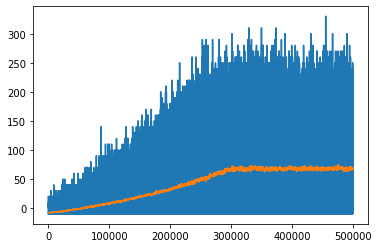

In [9]:
# Plot rewards
plt.plot(range(len(rewards)), rewards)
# Plot moving average
plt.plot(range(len(rewards)), pd.Series(rewards).rolling(1000).mean())

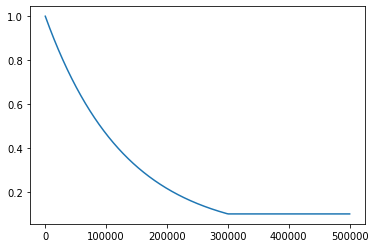

In [10]:
plt.plot(range(len(eps)), eps)

#### Visualize results

In [11]:
# # # Replay with last policy
old_eps = my_algo.epsilon
my_algo.epsilon = 0
play_epoch(algo = my_algo, env = env, render = True)
my_algo.epsilon = old_eps

In [12]:
type(my_algo.Q)

numpy.ndarray

In [25]:
# np.save('../../../Tests/QL_results/QL_epochs_500000_batch_1000_x_5000_.npy', my_algo.Q)

In [24]:
os.getcwd()

'/home/jonas/Documents/University/RLDMUU/RL_Project/gym-Snake/gym_Snake/envs'